# Router
![Router](images/router.png)

In [33]:
import requests
import os
from dotenv import load_dotenv

load_dotenv()
api_key = os.getenv("WEATHER_API_KEY")

def get_detailed_weather_weatherapi(city: str) -> str:
    """
    Fetches an extended weather report, including air quality, for a given city using WeatherAPI.

    Parameters:
        city (str): The name of the city to get the weather for.
        api_key (str): Your WeatherAPI key.

    Returns:
        str: A detailed weather and air quality report as a text message.
    """
    base_url = "http://api.weatherapi.com/v1/current.json"
    params = {
        "key": api_key,
        "q": city,
        "aqi": "yes"  # Include air quality data
    }
    
    try:
        response = requests.get(base_url, params=params)
        data = response.json()
        
        if response.status_code == 200:
            # Extract key weather details
            location = data["location"]["name"]
            country = data["location"]["country"]
            temperature = data["current"]["temp_c"]
            feels_like = data["current"]["feelslike_c"]
            condition = data["current"]["condition"]["text"]
            wind_speed = data["current"]["wind_kph"]
            wind_direction = data["current"]["wind_dir"]
            humidity = data["current"]["humidity"]
            cloudiness = data["current"]["cloud"]
            last_updated = data["current"]["last_updated"]

            # Extract air quality data
            aqi_data = data["current"]["air_quality"]
            co = aqi_data.get("co", "N/A")  # Carbon Monoxide
            no2 = aqi_data.get("no2", "N/A")  # Nitrogen Dioxide
            o3 = aqi_data.get("o3", "N/A")  # Ozone
            pm10 = aqi_data.get("pm10", "N/A")  # Particulate Matter 10
            pm2_5 = aqi_data.get("pm2_5", "N/A")  # Particulate Matter 2.5
            so2 = aqi_data.get("so2", "N/A")  # Sulfur Dioxide

            # Build the detailed weather and air quality report
            weather_report = (
                f"Weather in {location}, {country}:\n"
                f"- Condition: {condition}\n"
                f"- Temperature: {temperature}°C (Feels like: {feels_like}°C)\n"
                f"- Wind: {wind_speed} kph, Direction: {wind_direction}\n"
                f"- Humidity: {humidity}%\n"
                f"- Cloudiness: {cloudiness}%\n"
                f"- Last updated: {last_updated}\n\n"
                f"Air Quality Index (AQI):\n"
                f"- CO (Carbon Monoxide): {co} µg/m³\n"
                f"- NO2 (Nitrogen Dioxide): {no2} µg/m³\n"
                f"- O3 (Ozone): {o3} µg/m³\n"
                f"- PM10 (Particulate Matter <10µm): {pm10} µg/m³\n"
                f"- PM2.5 (Particulate Matter <2.5µm): {pm2_5} µg/m³\n"
                f"- SO2 (Sulfur Dioxide): {so2} µg/m³"
            )
            return weather_report
        else:
            return f"Error: {data.get('error', {}).get('message', 'Unable to fetch weather data')}"
    except Exception as e:
        return f"An error occurred: {str(e)}"

city_name = "Berlin"
print(get_detailed_weather_weatherapi(city_name))

Weather in Berlin, Germany:
- Condition: Overcast
- Temperature: 5.4°C (Feels like: 3.6°C)
- Wind: 7.9 kph, Direction: WNW
- Humidity: 93%
- Cloudiness: 75%
- Last updated: 2025-01-15 17:00

Air Quality Index (AQI):
- CO (Carbon Monoxide): 460.65 µg/m³
- NO2 (Nitrogen Dioxide): 62.345 µg/m³
- O3 (Ozone): 32.0 µg/m³
- PM10 (Particulate Matter <10µm): 26.085 µg/m³
- PM2.5 (Particulate Matter <2.5µm): 19.425 µg/m³
- SO2 (Sulfur Dioxide): 2.96 µg/m³


In [34]:
from langchain_openai import ChatOpenAI
import json

# OPENAI_API_KEY environment variable must be set
llm = ChatOpenAI(model="gpt-4o-mini")
llm_tools = llm.bind_tools([get_detailed_weather_weatherapi])

tool_call = llm_tools.invoke([HumanMessage(content=f"How is the weather in Berlin?")])

print(json.dumps(vars(tool_call), indent=4))

{
    "content": "",
    "additional_kwargs": {
        "tool_calls": [
            {
                "id": "call_jno14mUv1AZ0KDj9DDeSFrHb",
                "function": {
                    "arguments": "{\"city\":\"Berlin\"}",
                    "name": "get_detailed_weather_weatherapi"
                },
                "type": "function"
            }
        ],
        "refusal": null
    },
    "response_metadata": {
        "token_usage": {
            "completion_tokens": 19,
            "prompt_tokens": 94,
            "total_tokens": 113,
            "completion_tokens_details": {
                "accepted_prediction_tokens": 0,
                "audio_tokens": 0,
                "reasoning_tokens": 0,
                "rejected_prediction_tokens": 0
            },
            "prompt_tokens_details": {
                "audio_tokens": 0,
                "cached_tokens": 0
            }
        },
        "model_name": "gpt-4o-mini-2024-07-18",
        "system_fingerprint": "fp

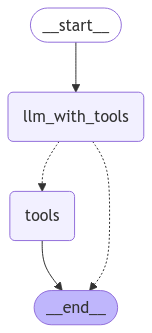

In [35]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def llm_with_tools(state: MessagesState):
    return {"messages": [llm_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)

builder.add_node("llm_with_tools", llm_with_tools)
builder.add_node("tools", ToolNode([get_detailed_weather_weatherapi]))

builder.add_edge(START, "llm_with_tools")
builder.add_conditional_edges(
    "llm_with_tools",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="How is the weather in Berlin?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

How is the weather in Berlin?
================================== Ai Message ==================================
Tool Calls:
  get_detailed_weather_weatherapi (call_wEEY5chjyUq1eg9kthml0dGQ)
 Call ID: call_wEEY5chjyUq1eg9kthml0dGQ
  Args:
    city: Berlin
================================= Tool Message =================================
Name: get_detailed_weather_weatherapi

Weather in Berlin, Germany:
- Condition: Overcast
- Temperature: 5.4°C (Feels like: 3.4°C)
- Wind: 8.6 kph, Direction: WNW
- Humidity: 93%
- Cloudiness: 75%
- Last updated: 2025-01-15 16:15

Air Quality Index (AQI):
- CO (Carbon Monoxide): 399.6 µg/m³
- NO2 (Nitrogen Dioxide): 46.99 µg/m³
- O3 (Ozone): 38.0 µg/m³
- PM10 (Particulate Matter <10µm): 23.865 µg/m³
- PM2.5 (Particulate Matter <2.5µm): 17.76 µg/m³
- SO2 (Sulfur Dioxide): 2.22 µg/m³


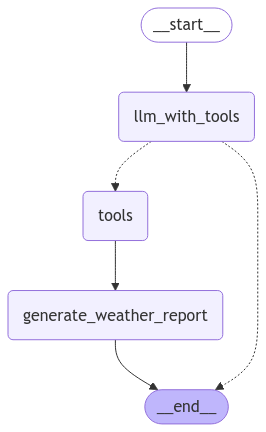

In [37]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Nodes
def llm_with_tools(state: MessagesState):
    return {"messages": [llm_tools.invoke(state["messages"])]}

def generate_weather_report(state: MessagesState):
    # Extract the weather table from the last message
    weather_table = state["messages"][-1].content

    prompt = f"""
    You are a friendly and chatty weather reporter who shares the weather as if you’re experiencing it yourself in the location. 
    Your goal is to describe the weather in a way that feels personal, engaging, and easy to understand. 
    Use the provided data to create a conversational response that includes feelings and suggests possible activities based on the weather.

    Here is the weather data:
    {weather_table}
    
    Use the data above to create a response. Here's the tone you're aiming for:
    1. Friendly and casual, like you're talking to a friend.
    2. Include your personal perspective, as if you’re sitting in this weather right now.
    3. Suggest one or two activities based on the weather.
    4. Make your answer short: just one or two sentences.
    """

    state["messages"].append(HumanMessage(content=prompt))
    return {"messages": [llm_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("llm_with_tools", llm_with_tools)
builder.add_node("tools", ToolNode([get_detailed_weather_weatherapi]))
builder.add_node("generate_weather_report", generate_weather_report)

builder.add_edge(START, "llm_with_tools")
builder.add_conditional_edges(
    "llm_with_tools",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "generate_weather_report")
builder.add_edge("generate_weather_report", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="How are you today?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

How are you today?
================================== Ai Message ==================================

I'm just a program, so I don't have feelings, but I'm here and ready to assist you! How can I help you today?


In [39]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="How is the weather in Berlin today?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

How is the weather in Berlin today?
================================== Ai Message ==================================
Tool Calls:
  get_detailed_weather_weatherapi (call_lVlpXUurZJMyzJGCL3HCO2xL)
 Call ID: call_lVlpXUurZJMyzJGCL3HCO2xL
  Args:
    city: Berlin
================================= Tool Message =================================
Name: get_detailed_weather_weatherapi

Weather in Berlin, Germany:
- Condition: Overcast
- Temperature: 5.4°C (Feels like: 3.4°C)
- Wind: 8.6 kph, Direction: WNW
- Humidity: 93%
- Cloudiness: 75%
- Last updated: 2025-01-15 17:00

Air Quality Index (AQI):
- CO (Carbon Monoxide): 399.6 µg/m³
- NO2 (Nitrogen Dioxide): 46.99 µg/m³
- O3 (Ozone): 38.0 µg/m³
- PM10 (Particulate Matter <10µm): 23.865 µg/m³
- PM2.5 (Particulate Matter <2.5µm): 17.76 µg/m³
- SO2 (Sulfur Dioxide): 2.22 µg/m³
================================ Human Message =================================


    You 